In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Tutorial B4: In silico Saturation Mutagenesis (ISM)

> predict + ersatz (substitute) + predict

In silico marginalizations show the effect on model predictions that each motif has, marginalized over a large number of background regions; in contrast, <i>in silico saturation mutagenesis</i> (ISM) shows that influence that each <i>character</i> has within an <i>actual</i> sequence context (not synthetic background sequences). Rather than creating ersatz sequences containing a motif  and running them through a model, ISM allows one to evaluate drivers of predictions in real sequences. At a high level, ISM operates by changing the character at each position to each other potential character, one at a time, and evaluating the difference in prediction before and after the substitution. This difference is interpreted as a form of importance/attribution, with a higher magnitude value meaning that changing the character has a large impact and is likely very important.

Although this function will, by default, provide an attribution score that is the position-mean-normalized difference in predictions, one can also get the underlying predictions before and after substitutions. This functionality means that if you disagree with the specific distance function used to score importances, or you want to do something else with the predictions, or your model yields multiple forms of outputs and you want to do something more complex to handle them all, you can still use the same function.

Let's demonstrate how to use this using Beluga / DeepSEA.

In [2]:
import torch
from model import Beluga

model = Beluga()
model.load_state_dict(torch.load("deepsea.beluga.torch"))

<All keys matched successfully>

First,  we need a sequence to analyze. Because ISM is usually performed on actual genomic sequence (or constructs), we will pull a sequence from the human genome. You will need to download the hg38 fasta file from https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz and unzip it to run the rest of this notebook yourself.

In [3]:
import pyfaidx
from tangermeme.utils import one_hot_encode
from tangermeme.utils import random_one_hot
from tangermeme.ersatz import substitute

seq = pyfaidx.Fasta("hg38.fa")['chr1'][31202000:31202000+2000].seq.upper()
X = one_hot_encode(seq).unsqueeze(0)
X.shape

torch.Size([1, 4, 2000])

We can run ISM on a sequence (or a batch of sequences) using the `saturation_mutagenesis` function. This function takes in a model, the batch of sequences, and other optional arguments, and returns the original predictions as well as the predictions on each mutation. Because it is built on the `predict` method, all of benefits of that core function are available here as well, e.g., moving the model and data to/from a device, automatic batching of examples, etc. 

In [4]:
from tangermeme.ism import saturation_mutagenesis

X_attr = saturation_mutagenesis(model, X, device='cpu')
X_attr.shape

torch.Size([1, 4, 2000])

By default this will yield the average attribution across all tasks in the DeepSEA model. Specifically, the attribution scores returned by this function are the difference in predictions before and after each substitution after subtracting out the mean value at each position and averaging across all tasks. Importantly, some attribution scores derived from saturation mutagenesis involve dividing by the standard deviation so that the scores represent some notion of a Z-score, but `tangermeme` does not do that because Z-score normalization means that the magnitude of attributions is ~the same regardless of how strong the predictions for those regions are. Basically, you could no longer compare two regions head-to-head because the scale will be uniform regardless of the true strength of the signal.

#### Focusing on a subset of tasks or just one task

Sometimes, you do not want to average your attributions across all tasks. DeepSEA has thousands of tasks that represent diverse activity -- averaging attributions across transcription, protein binding, and histone modification outputs would be noisy and difficult to deconvolve into what patterns influence what output. Usually, you would like to focus on a single output or a small number of outputs at a time. There are two ways to do this with `tangermeme`. The first is to write a custom class that slices out only the outputs you want. This approach is very flexible because it allows you to do anything you want to the outputs of the trained models, e.g., transform or aggregate them in some custom way in addition to just slicing. In the example below we will be slicing out only one task that we care about. Keep in mind that the resulting tensor must still have two dimensions where the second dimension is the number of targets, even if the number of targets is 1.

In [5]:
class SliceWrapper(torch.nn.Module):
    def __init__(self, model, target):
        super(SliceWrapper, self).__init__()
        self.model = model
        self.target = target

    def forward(self, X):
        return self.model(X)[:, self.target:self.target+1]

wrapper = SliceWrapper(model, target=57)
X_attr = saturation_mutagenesis(wrapper, X, device='cpu')  # Note that we are passing in `wrapper` not `model`
X_attr.shape

torch.Size([1, 4, 2000])

If your model is like DeepSEA in the sense that it returns one tensor and you want to focus on only one output at a time you can also pass in the `target` parameter. This will do the exact same thing as the code above but only works when you have a single tensor being returned and want to slice out a single output.

In [6]:
X_attr2 = saturation_mutagenesis(model, X, device='cpu', target=57)  # Note that we are passing in `model` not `wrapper`
torch.abs(X_attr - X_attr2).max()

tensor(0.)

Note that we are getting the exact same results using the `target` parameter or writing a custom wrapper.

We can then plot these attributions using the same `plot_logo` function we used to visualize the DeepLIFT/SHAP attributions. This function wraps `logomaker` with some additional functionality that we won't be using in this example. If we want to focus on attributions for the observed nucleotides, as opposed to hypothetical attributions of nucleotide substitutions, we can multiply by the one-hot encoded sequence. 

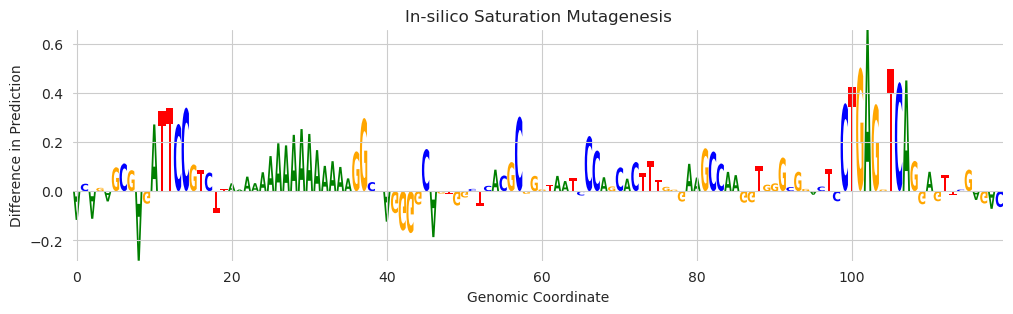

In [7]:
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
from tangermeme.plot import plot_logo

plt.figure(figsize=(12, 3))
ax = plt.subplot(111)
plot_logo(X_attr[0, :, 955:1075], ax=ax)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Difference in Prediction")
plt.title("In-silico Saturation Mutagenesis")
plt.show()

The attributions are highlighting several interesting patterns here. Most notably, on the right hand side, is our friend the AP-1 motif. However, the attributions for the rest of the sequence are not as clean. This is, unfortunately, in part due to DeepSEA generally having messier attributions than other models for technical reasons. There are two other patterns of interest, though. The ATTCC pattern is likely a TEAD motif. The large stretch of As is potentially a ZNF motif but could also some form of spurious pattern learned by the model.

Just to confirm that some of these features are real and that the implementation is working, we can consider the DeepLIFT/SHAP attributions at this locus as well. We do not expect the exact same magnitudes for the characters but the two methods should largely agree on the regions of high contiguous attribution.

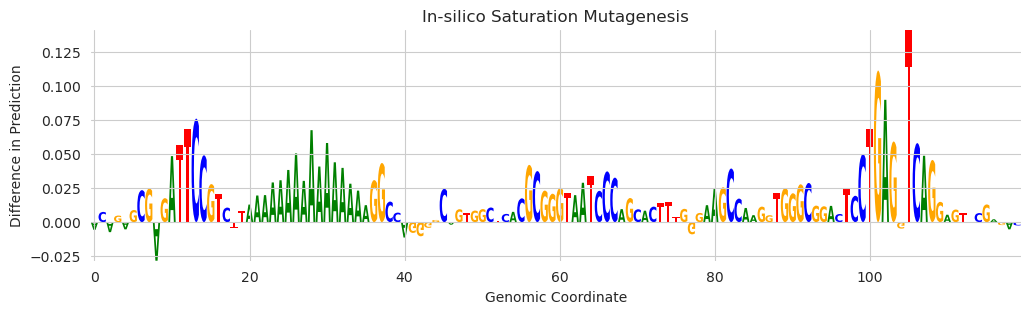

In [8]:
from tangermeme.deep_lift_shap import deep_lift_shap

X_attr3 = deep_lift_shap(model, X, device='cpu', target=57)

plt.figure(figsize=(12, 3))
ax = plt.subplot(111)
plot_logo(X_attr3[0, :, 955:1075], ax=ax)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Difference in Prediction")
plt.title("In-silico Saturation Mutagenesis")
plt.show()

Looks like all three of the features still have high attribution values. There do appear to be more high-attribution characters near the center of the sequence but, in general, the attributions from DeepSEA are somewhat noisy compared to other methods.

#### Hypothetical attributions

By default, `saturated_mutagenesis` only reports the attribution values for characters actually present in the sequence. This is to match the most common use-case of attribution algorithms where one wants to highlight the characters in a sequence driving predictions. However, just like with `deep_lift_shap`, we can get the hypothetical attributions of characters that were not actually present in the original sequence. In fact, these values have to be calculated as part of the saturation mutagenesis procedure because we need them to know what the position-specific mean values are to normalize by. We can get them the same way we get them in `deep_lift_shap`, by passing in `hypothetical=True`.

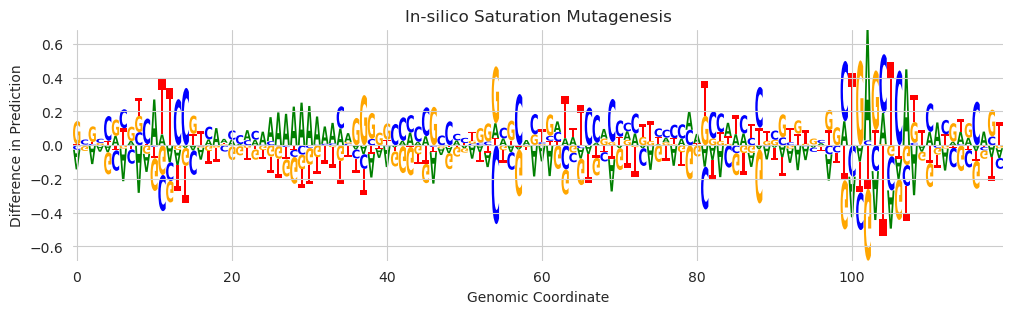

In [9]:
X_attr = saturation_mutagenesis(model, X, device='cpu', target=57, hypothetical=True)

plt.figure(figsize=(12, 3))
ax = plt.subplot(111)
plot_logo(X_attr[0, :, 955:1075], ax=ax)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Difference in Prediction")
plt.title("In-silico Saturation Mutagenesis")
plt.show()

#### Getting the raw outputs

Sometimes, you'd prefer to just get the raw predictions before and after each substitution. These predictions might be valuable in some other context or, perhaps, you want to implement your own method for aggregating them into a score function. If your model returns multiple tensors and you don't want to write a custom wrapper converting the output into a single tensor, getting the raw outputs is the only option for calculating attributions.

In [10]:
y_ref, y_ism = saturation_mutagenesis(model, X, device='cuda', raw_outputs=True)
y_ref.shape, y_ism.shape

(torch.Size([1, 2002]), torch.Size([1, 4, 2000, 2002]))

This function has two outputs: first, the predictions on the original sequence without any perturbations, and second, the predictions for each sequence given each possible substitution. Hence, the second output has two additional axes compared with the first output that are the length of the alphabet and the length of the sequence. The first and last dimensions of this second output should be the same as the first and second output as the first output. 

You can then choose the way that you want to combine these predictions to get an attribution value. A simple way to do it is just take the difference in predictions, which can be done like this:

In [11]:
y_attr1 = y_ism - y_ref[:, None, None]
y_attr1.shape

torch.Size([1, 4, 2000, 2002])

For some forms out output, such as probability distributions, one may want to use a more complicated form of distance such as Jensen-Shannon or KL-divergences. 

##### Windowed ISM

Sometimes, the sequences that you are evaluating are very long or there are too many of them and so you do not have the compute power to comprehensively run ISM everywhere. Sometimes, there is only a small window of interest and it would be a waste to run ISM everywhere. For example, you may have a list of motif hits and you want to evaluate each one to see whether that motif is driving activity without having to waste time substitutions outside those motif hits. For both situations you may want to run ISM only on a portion of the input window instead of on everything. `saturated_mutagenesis` allows you to run ISM from only a start coordinate to an end coordinate and save time.

In [12]:
X_attr_w = saturation_mutagenesis(model, X, start=955, end=1075, target=57, device='cpu')
X_attr_w.shape

torch.Size([1, 4, 120])

The results will be identical to performing ISM across the entire example and then subsetting on only the positions of interest. This is because each substitution is an independent operation and so running only a subset of substitutions does not effect their output. 

We can confirm that the results are the same by plotting the attributions for the window we calculated over.

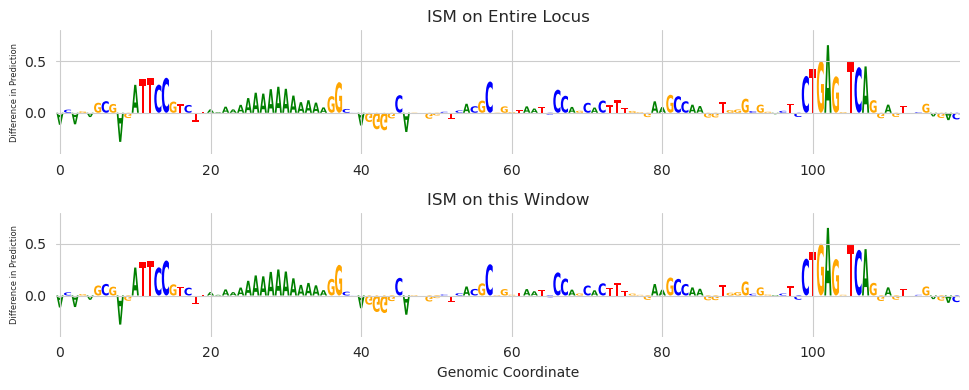

In [13]:
plt.figure(figsize=(10, 4))
ax = plt.subplot(211)
plot_logo((X_attr * X)[0, :, 955:1075], ax=ax)
plt.ylabel("Difference in Prediction", fontsize=6)
plt.title("ISM on Entire Locus")
plt.ylim(-0.4, 0.8)

ax = plt.subplot(212)
plot_logo((X_attr_w * X[:, :, 955:1075])[0], ax=ax)
plt.ylim(-0.4, 0.8)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Difference in Prediction", fontsize=6)
plt.title("ISM on this Window")

plt.tight_layout()
plt.show()

We can time these two versions to see what sort of speed gain we get.

In [14]:
%timeit -n 1 -r 1 saturation_mutagenesis(model, X, start=955, end=1075, target=57, device='cpu')
%timeit -n 1 -r 1 saturation_mutagenesis(model, X, target=57, device='cpu')

4.17 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1min 14s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


As you might expect, we get roughly a ~15x speed gain when only looking at ~5% of the sequence. Focusing on known windows can make ISM feasible, particularly when you actually need the outputs from each task the model is predicting.

As an example of a situation where this would be useful: imagine that you have a set of coordinates you want to investigate. Perhaps, these are motif hits according to a method like FIMO. You can quickly calculate ISM scores for each motif by running windowed ISM for each set of coordinates and summing the attribution values across the width.

In [15]:
import numpy
import pandas

starts = numpy.array([0, 720, 990, 1050, 1100, 1500])  # Only 1050 is an actual motif, the rest are for demonstration
y_attr = []

for start in starts:
    end = start + 20

    X_attr_ = saturation_mutagenesis(model, X, start=start, end=end, target=57, device='cpu') * X[:, :, start:end]
    y_attr.append(X_attr_.sum().item())

df = pandas.DataFrame({'start': starts, 'end': starts+20, 'score': y_attr})
df

,start,end,score
0,0,20,0.006867
1,720,740,-0.467693
2,990,1010,-0.112934
3,1050,1070,3.906376
4,1100,1120,-0.141630
5,1500,1520,0.051178


The actual motif, from 1050-1070, has significantly higher attribution than the others. And it only took ~1-2 seconds to calculate all of these on a CPU, rather than the ~minute that it takes to calculate across the entire sequence.